<h1>Using SHAP for measuring the contirbution from the features</h1>

This notebook is provided to show the usage of SHAP for measuring the contirbution from the features.

NOTE: The script used 3rd module <a href=https://github.com/slundberg/shap>SHAP</a> for feature measuring and <a href=https://logomaker.readthedocs.io/en/latest/examples.html>Logo maker</a> for LOGO figure plotting.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook'</b>, then we need to add the search path and import the modules.

Please install <b>logomaker, SHAP, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../tool/libs')
sys.path.append('../')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
import numpy as np
import tensorflow as tf
from utils import TextDecorate, evalStrList

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #if CUDA related error occured, uncomment this line

Before using SHAP, we need the model and the data.

<h3>1.1 Model building</h3>

Firstly, using running.py  could build a model, the commands are available in the <a href=https://github.com/jingry/autoBioSeqpy/tree/2.0/examples/T3T4>T3T4</a> case, here we use the final hybrid model, in the root path of autoBioSeqpy, execute:

<b>python running.py --dataType protein other --dataEncodingType dict other --dataTrainFilePaths examples/T3T4/dataset/trainT3.txt examples/T3T4/dataset/trainT4.txt examples/T3T4/feature/trainT3_AAC_DC.txt examples/T3T4/feature/trainT4_AAC_DC.txt --dataTrainLabel 1 0 1 0 --dataTestFilePaths examples/T3T4/dataset/testT3.txt examples/T3T4/dataset/testT4.txt examples/T3T4/feature/testT3_AAC_DC.txt examples/T3T4/feature/testT4_AAC_DC.txt --dataTestLabel 1 0 1 0 --modelLoadFile examples/T3T4/model/RNN_hybrid.py examples/T3T4/model/DNN_hybrid.py --verbose 1 --outSaveFolderPath tmpOut --savePrediction 1 --saveFig 1 --batch_size 25 --epochs 40 --shuffleDataTrain 1 --showFig 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt --spcLen 1500 1500  --dataTrainModelInd 0 0 1 1  --dataTestModelInd 0 0 1 1
</b>

The outputs will be saved at <b>../tmpOut</b>, including the parameters, the path of the data and constructure of the model.

If users would like to change to other model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<h3>1.2 Parameter pasering and data loading</h3>
The parameters are saved in <b>../tmoOut/parameters.txt</b>, we can get the information easily by using the <b>paraParser</b> module.

In [4]:
paraFile = '../tmpOut/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['protein', 'other']
'dataEncodingType': ['dict', 'other']
'spcLen': [1500, 1500]
'firstKernelSize': []
'dataTrainFilePaths': ['examples/T3T4/dataset/trainT3.txt', 'examples/T3T4/dataset/trainT4.txt', 'examples/T3T4/feature/trainT3_AAC_DC.txt', 'examples/T3T4/feature/trainT4_AAC_DC.txt']
'dataTrainLabel': [1, 0, 1, 0]
'dataTestFilePaths': ['examples/T3T4/dataset/testT3.txt', 'examples/T3T4/dataset/testT4.txt', 'examples/T3T4/feature/testT3_AAC_DC.txt', 'examples/T3T4/feature/testT4_AAC_DC.txt']
'dataTestLabel': [1, 0, 1, 0]
'dataTrainModelInd': [0, 0, 1, 1]
'dataTestModelInd': [0, 0, 1, 1]
'outSaveFolderPath': 'tmpOut'
'showFig': True
'saveFig': True
'figDPI': 300
'savePrediction': True
'dataSplitScale': None
'modelLoadFile': ['examples/T3T4/model/RNN_hybrid.py', 'examples/T3T4/model/DNN_hybrid.py']
'weightLoadFile': []
'shuffleDataTrain': True
'shuffleDataTest': False
'batch_size': 25
'epochs': 40
'useKMer': []
'KMerNum': []
'inputLength': []
'loss': 'binary_crossentropy'


Then using <b>predicting</b> module could help us get the model and the datasets.

In [5]:
import predicting

Here we need some modification to specify the dataset due to the layer plotting needs the training dataset.

In [6]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']

In [7]:
os.chdir('../')#to the root path of autoBioSeqpy

In [8]:
predictedLabel,predicted_Probability,testNameLists,testDataMats,testLabelArr,model = predicting.predict(paraDict)    




Enconding protein data for model 0 ...
Reading CSV-like data for model 1 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.
begin to prepare model...
Checking module file for modeling
Loading module and weight file
Building model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Module loaded, generating the summary of the module
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 420)          0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  (None, 1500)         0                                            
____________

Please note that the test label will NOT used for predicting, thus we have to generate it manually.

In [9]:
featureGenerators = []
dataTypeList = paraDict['dataType']
verbose = False
dataEncodingType = paraDict['dataEncodingType']
KMerNumList = useKMerList = [False] * 400
dataTestFilePaths = paraDict['dataTestFilePaths']
modelLoadFile = paraDict['modelLoadFile']
dataTestModelInd = paraDict['dataTestModelInd']
spcLen = paraDict['spcLen']
for i,subDataType in enumerate(dataTypeList):
    if subDataType.lower() == 'protein':
        if verbose:
            td.printC('Enconding protein data for model %d ...' %i,'b')
        featureGenerator = dataProcess.ProteinFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'dna':
        if verbose:
            td.printC('Enconding DNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.DNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'rna':
        if verbose:
            td.printC('Enconding RNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.RNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'other':
        if verbose:
            td.printC('Reading CSV-like data for model %d ...' %i,'b')
        featureGenerator = dataProcess.OtherFeatureGenerator()
    else:
        td.printC('Unknow dataType %r, please use \'protein\', \'dna\' ,\'rna\' or \'other\'' %subDataType, 'r')
    featureGenerators.append(featureGenerator)
    assert subDataType.lower() in ['protein','dna','rna','other']

if verbose:
    td.printC('Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...','b')
assert len(dataTestFilePaths) > 0

if verbose:
    td.printC('Begin to generate test dataset...','b')

testDataLoadDict = {}    
for modelIndex in range(len(modelLoadFile)):
    testDataLoadDict[modelIndex] = []
#    testDataLoaders = []
for i,dataPath in enumerate(dataTestFilePaths):
    if i < len(dataTestModelInd):
        modelIndex = dataTestModelInd[i]
    else:
        modelIndex = 0
    featureGenerator = featureGenerators[modelIndex]
    dataLoader = dataProcess.DataLoader(label = paraDict['dataTestLabel'][i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = spcLen[modelIndex])
    testDataLoadDict[modelIndex].append(dataLoader)

testDataMats = []
testLabelArrs = []
testNameLists = []
for modelIndex in range(len(modelLoadFile)):
    testDataLoaders = testDataLoadDict[modelIndex]
    testDataSetCreator = dataProcess.DataSetCreator(testDataLoaders)
    testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
    testDataMats.append(testDataMat)
    testLabelArrs.append(testLabelArr)
    testNameLists.append(nameList)
if verbose:
    td.printC('Test datasets generated.','g')
nameTemp = testNameLists[0]    
testDataMats, testLabelArrs, sortedIndexes = dataProcess.matAlignByName(testDataMats,nameTemp,testLabelArrs,testNameLists)
testNameLists = [nameTemp] * len(testNameLists)

tmpTempLabel = testLabelArrs[0]

Few printing operations for display the current information.

In [10]:
testLabelArr.shape

(474,)

In [11]:
print('%d matrix generated:\n' %(len(testDataMats)))
for i in range(len(testDataMats)):
    print('Matrix and label %d:' %i)
    print(testDataMats[i])
    print(testLabelArrs[i])
    print('\n')

2 matrix generated:

Matrix and label 0:
[[12 18 17 ... 20 20 20]
 [12  5  7 ... 20 20 20]
 [12 10  3 ... 20 20 20]
 ...
 [12 13 11 ... 20 20 20]
 [12  3  5 ... 20 20 20]
 [12  1  1 ... 20 20 20]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Before using SHAP, here provid a brief way to visualize the parameters from the embedding layer.

In [12]:
model.layers[3].get_config()

{'name': 'embedding_1',
 'trainable': True,
 'batch_input_shape': (None, 1500),
 'dtype': 'float32',
 'input_dim': 26,
 'output_dim': 256,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 1500}

In [13]:
w = model.layers[3].get_weights()

In [14]:
import analysisPlot

In [15]:
w1 = (w[0] - np.min(w[0])) / (np.max(w[0]) - np.min(w[0]))

/mnt/d/workspace/autoBioSeqpy2/analysisPlot.py:120: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  my_cmap.set_under(color_bar_set_under)
/mnt/d/workspace/autoBioSeqpy2/analysisPlot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(xstic)+1)


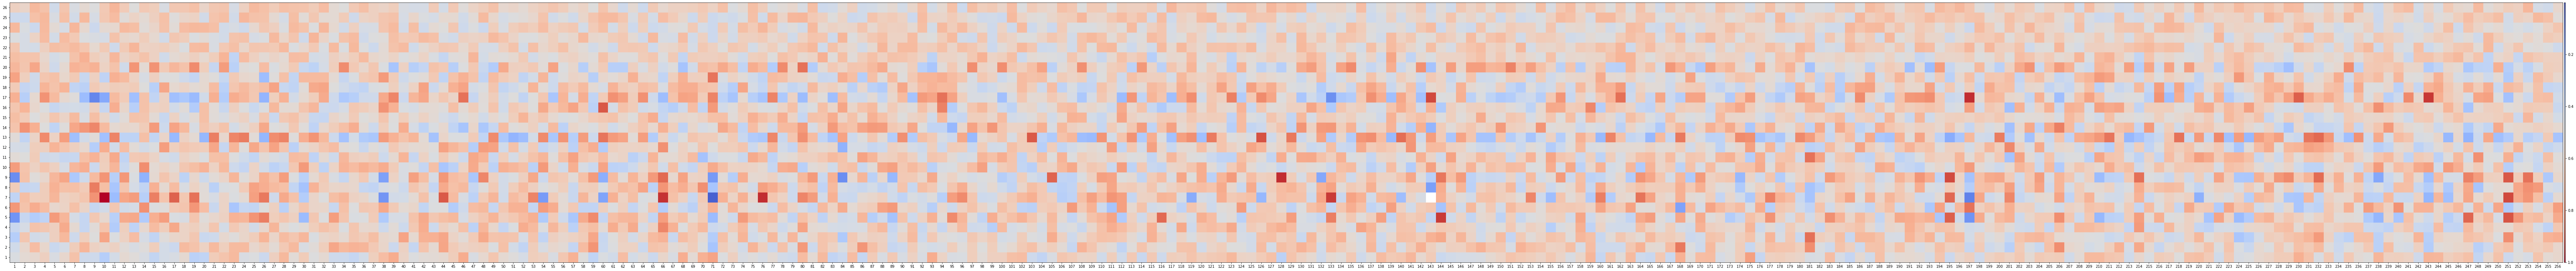

In [16]:
analysisPlot.showMatWithVal(w1,figSize=(128,32),showText=False,cmapName='coolwarm')

<h2>2 Using SHAP for feature measuring</h2>
SHAP is a good tool for understanding the contribution from the features in every sample. SHAP provides some functions for the visualization of the features, but is not fit for T3T4 data due to the large scale of the features (1500 + 420). Thus here we only use SHAP for generating the SHAP values and then plot them in our way.

<b>Note</b>:Currently (2020.11.23) SHAP only support TF 1.x without significant issue, if change TF to 2.x, sometimes the SHAP will not work . In this work, autoBioSeqpy uses Keras with TF backend, thus please make sure the version of TF is correctly set. The model from autoBioSeqpy is compatible with both TF 1.x and 2.x and thus all the code in section 1 can be executed correctly. 

<h3>2.1 Preparation</h3>
SHAP need the TF/Torch/Keras model and the related inputs, which are generated in the last section, here just use them.

In [17]:
import shap

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 420)          0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  (None, 1500)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 210)          88410       dense_1_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1500, 256)    6656        embedding_1_input[0][0]          
____________________________________________________________________________________________

Since keras model used in this work, get the session for further analysis.

If TF 2.x used, here an error would be occured.

In [19]:
from keras import backend as K
session = K.get_session()

In [20]:
explainer = shap.DeepExplainer(model, testDataMats,session=session)

keras is no longer supported, please use tf.keras instead.


<h3>2.2 Get the SHAP values</h3>
After the initialization of the model, the SHAP value is available by using the function <i>shap_values</i>. But it will take about <b>100</b> hours using i7-8700K in our test. Thus we provided another way that load our pre-calculated SHAP values from the <i>pickle</i> files.

<h4>2.2.1 Compute the SHAP values directly</h4>

In [ ]:
shap_values = explainer.shap_values(testDataMats)

In [ ]:
shap_values

<h4>2.2.2 Load the pre-calculated SHAP values</h4>

In [21]:
import pickle

In [22]:
with open('./notebook/LayerUMAP of T3T4 case for points extracting/tmpSHAPVAL.bin' , 'rb') as FID:
    shap_values = pickle.load(FID)

In [23]:
shap_values

[[array([[-5.31355436e-05, -2.11252992e-02, -7.23846628e-02, ...,
          -9.66520344e-05, -1.16544951e-04, -1.79906176e-04],
         [-9.79489370e-05,  2.02083776e-02, -4.51722944e-02, ...,
          -1.24872788e-04, -1.52869189e-04, -2.33651047e-04],
         [-8.79368362e-05,  2.65713431e-02, -3.17414867e-02, ...,
          -1.20732934e-04, -1.47302228e-04, -2.25685219e-04],
         ...,
         [-1.40660663e-04,  5.81750729e-02,  1.24379284e-02, ...,
          -1.15454207e-04, -1.43040911e-04, -2.16483364e-04],
         [-1.49131273e-04, -2.08223091e-02,  1.39811738e-02, ...,
          -1.16204392e-04, -1.43930163e-04, -2.17886517e-04],
         [-9.30817823e-05,  4.59300228e-02,  4.40396415e-02, ...,
          -1.23404322e-04, -1.50858384e-04, -2.30813214e-04]]),
  array([[ 1.42629838e-02,  3.84153353e-03,  2.84346067e-03, ...,
           1.68101940e-04, -2.07069967e-04,  5.58795438e-04],
         [ 5.99570635e-04, -2.53222563e-03,  1.09628695e-03, ...,
           1.75826711e

<h3>2.3 Visualize the SHAP values</h3>

Firstly, have a look of the format of SHAP values

In [24]:
print(len(shap_values))

1


In [25]:
print(len(shap_values[0]))

2


In [26]:
print(shap_values[0][0].shape)
print(shap_values[0][1].shape)

(474, 1500)
(474, 420)


In this work, the length of the sequence is set as 1500 and every sample has additional 420 features. Thus, it is clear that SHAP will score all the features of every samples respectively.

Now we can plot them separately, here is the plot of SHAP values of the sequences:

In [27]:
import analysisPlot

In [28]:
matForPlot = shap_values[0][0]

Since the SHAP values in a sample is comparable, a 0-1 scale is performed for every sample to make the plot better to look.

In [29]:
matForPlot = (matForPlot - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]]))) / (matForPlot.max(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])) - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])))

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
FixedFormatter should only be used together with FixedLocator


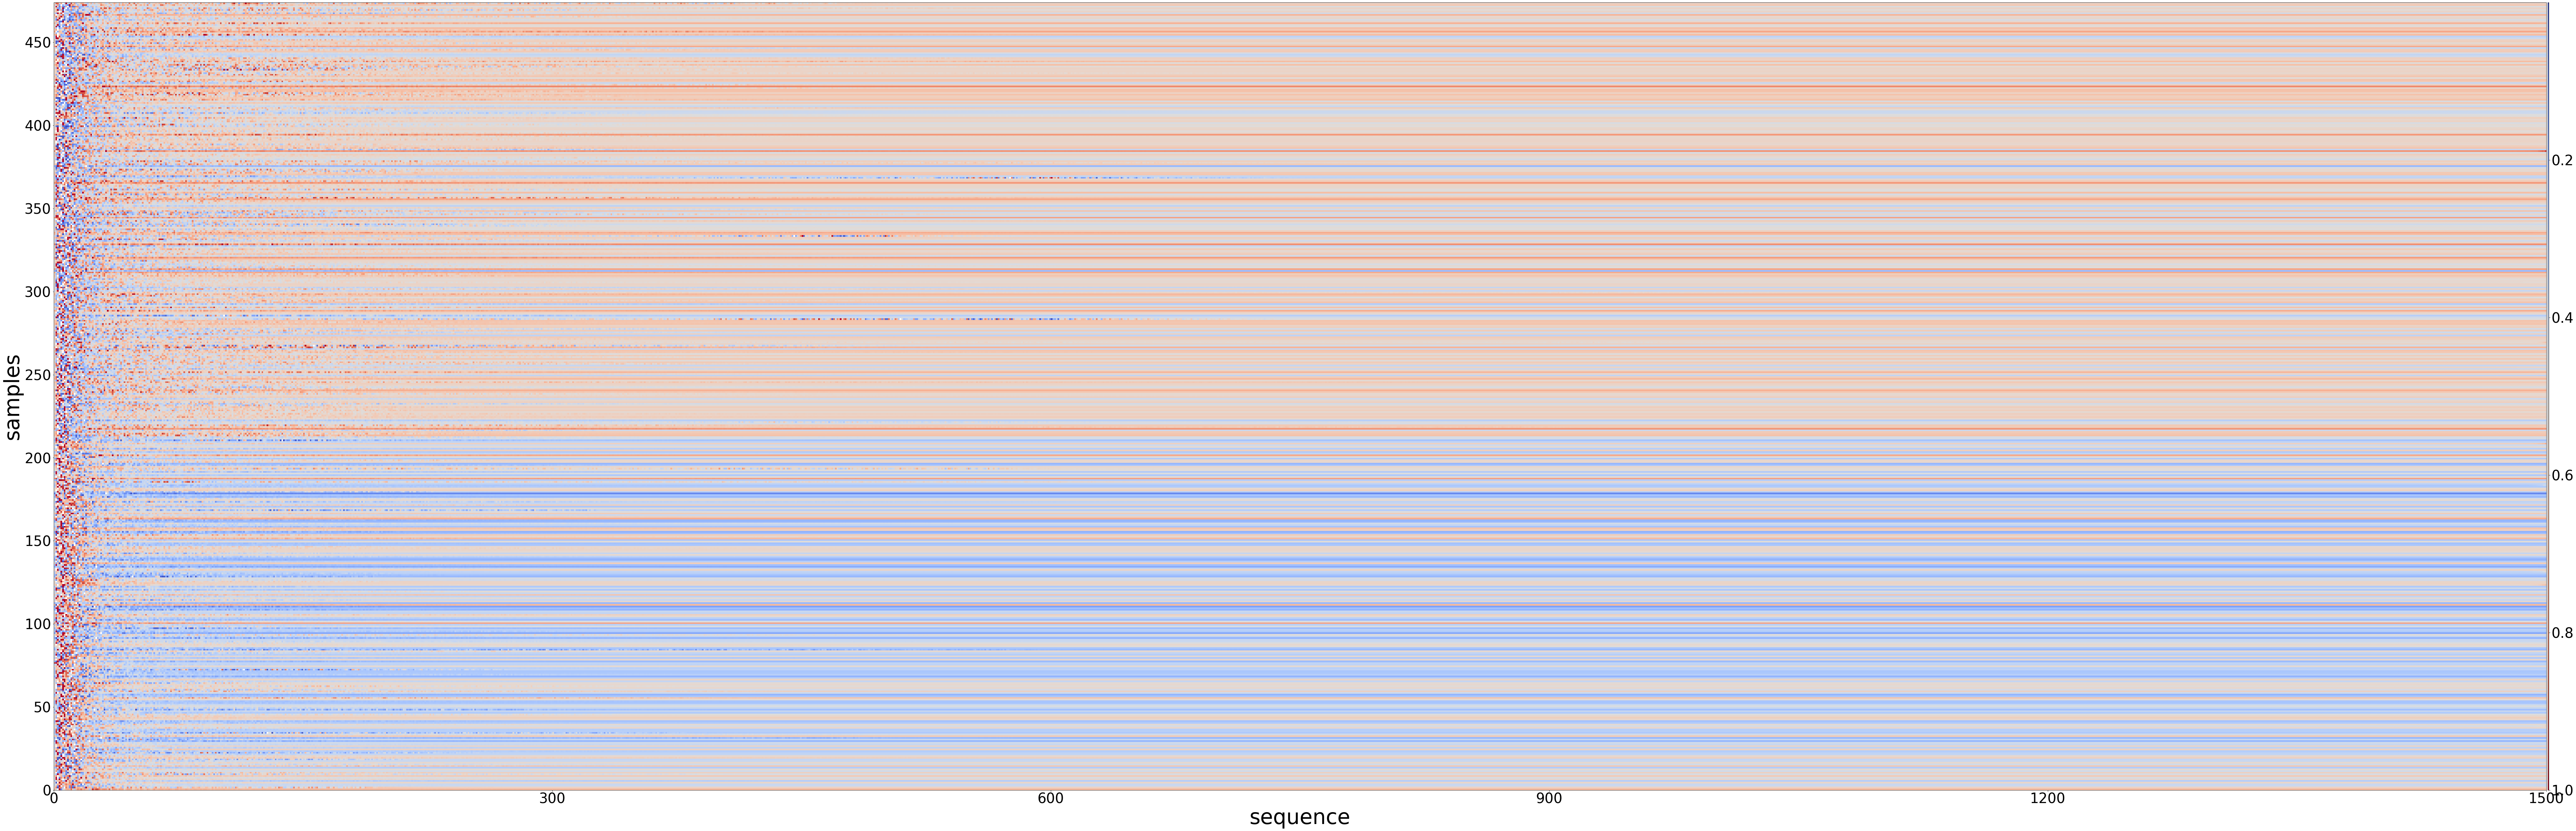

In [30]:
analysisPlot.showMatWithVal(matForPlot,showText=False,figSize=(128,64),cmapName='coolwarm',
                            yticks=np.arange(0,500,50),ytickLabels=np.arange(0,500,50),
                           xticks=np.arange(0,1501,300),xtickLabels=np.arange(0,1501,300),
                           xtitle='sequence',ytitle='samples',title_size=60,stick_size=40,
                            saveFig='./tmpOut/shapValT3T4.pdf',saveDpi=300)

Here is the plot of SHAP values of the features:

In [31]:
matForPlot = shap_values[0][1]
matForPlot = (matForPlot - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]]))) / (matForPlot.max(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])) - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])))

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
FixedFormatter should only be used together with FixedLocator


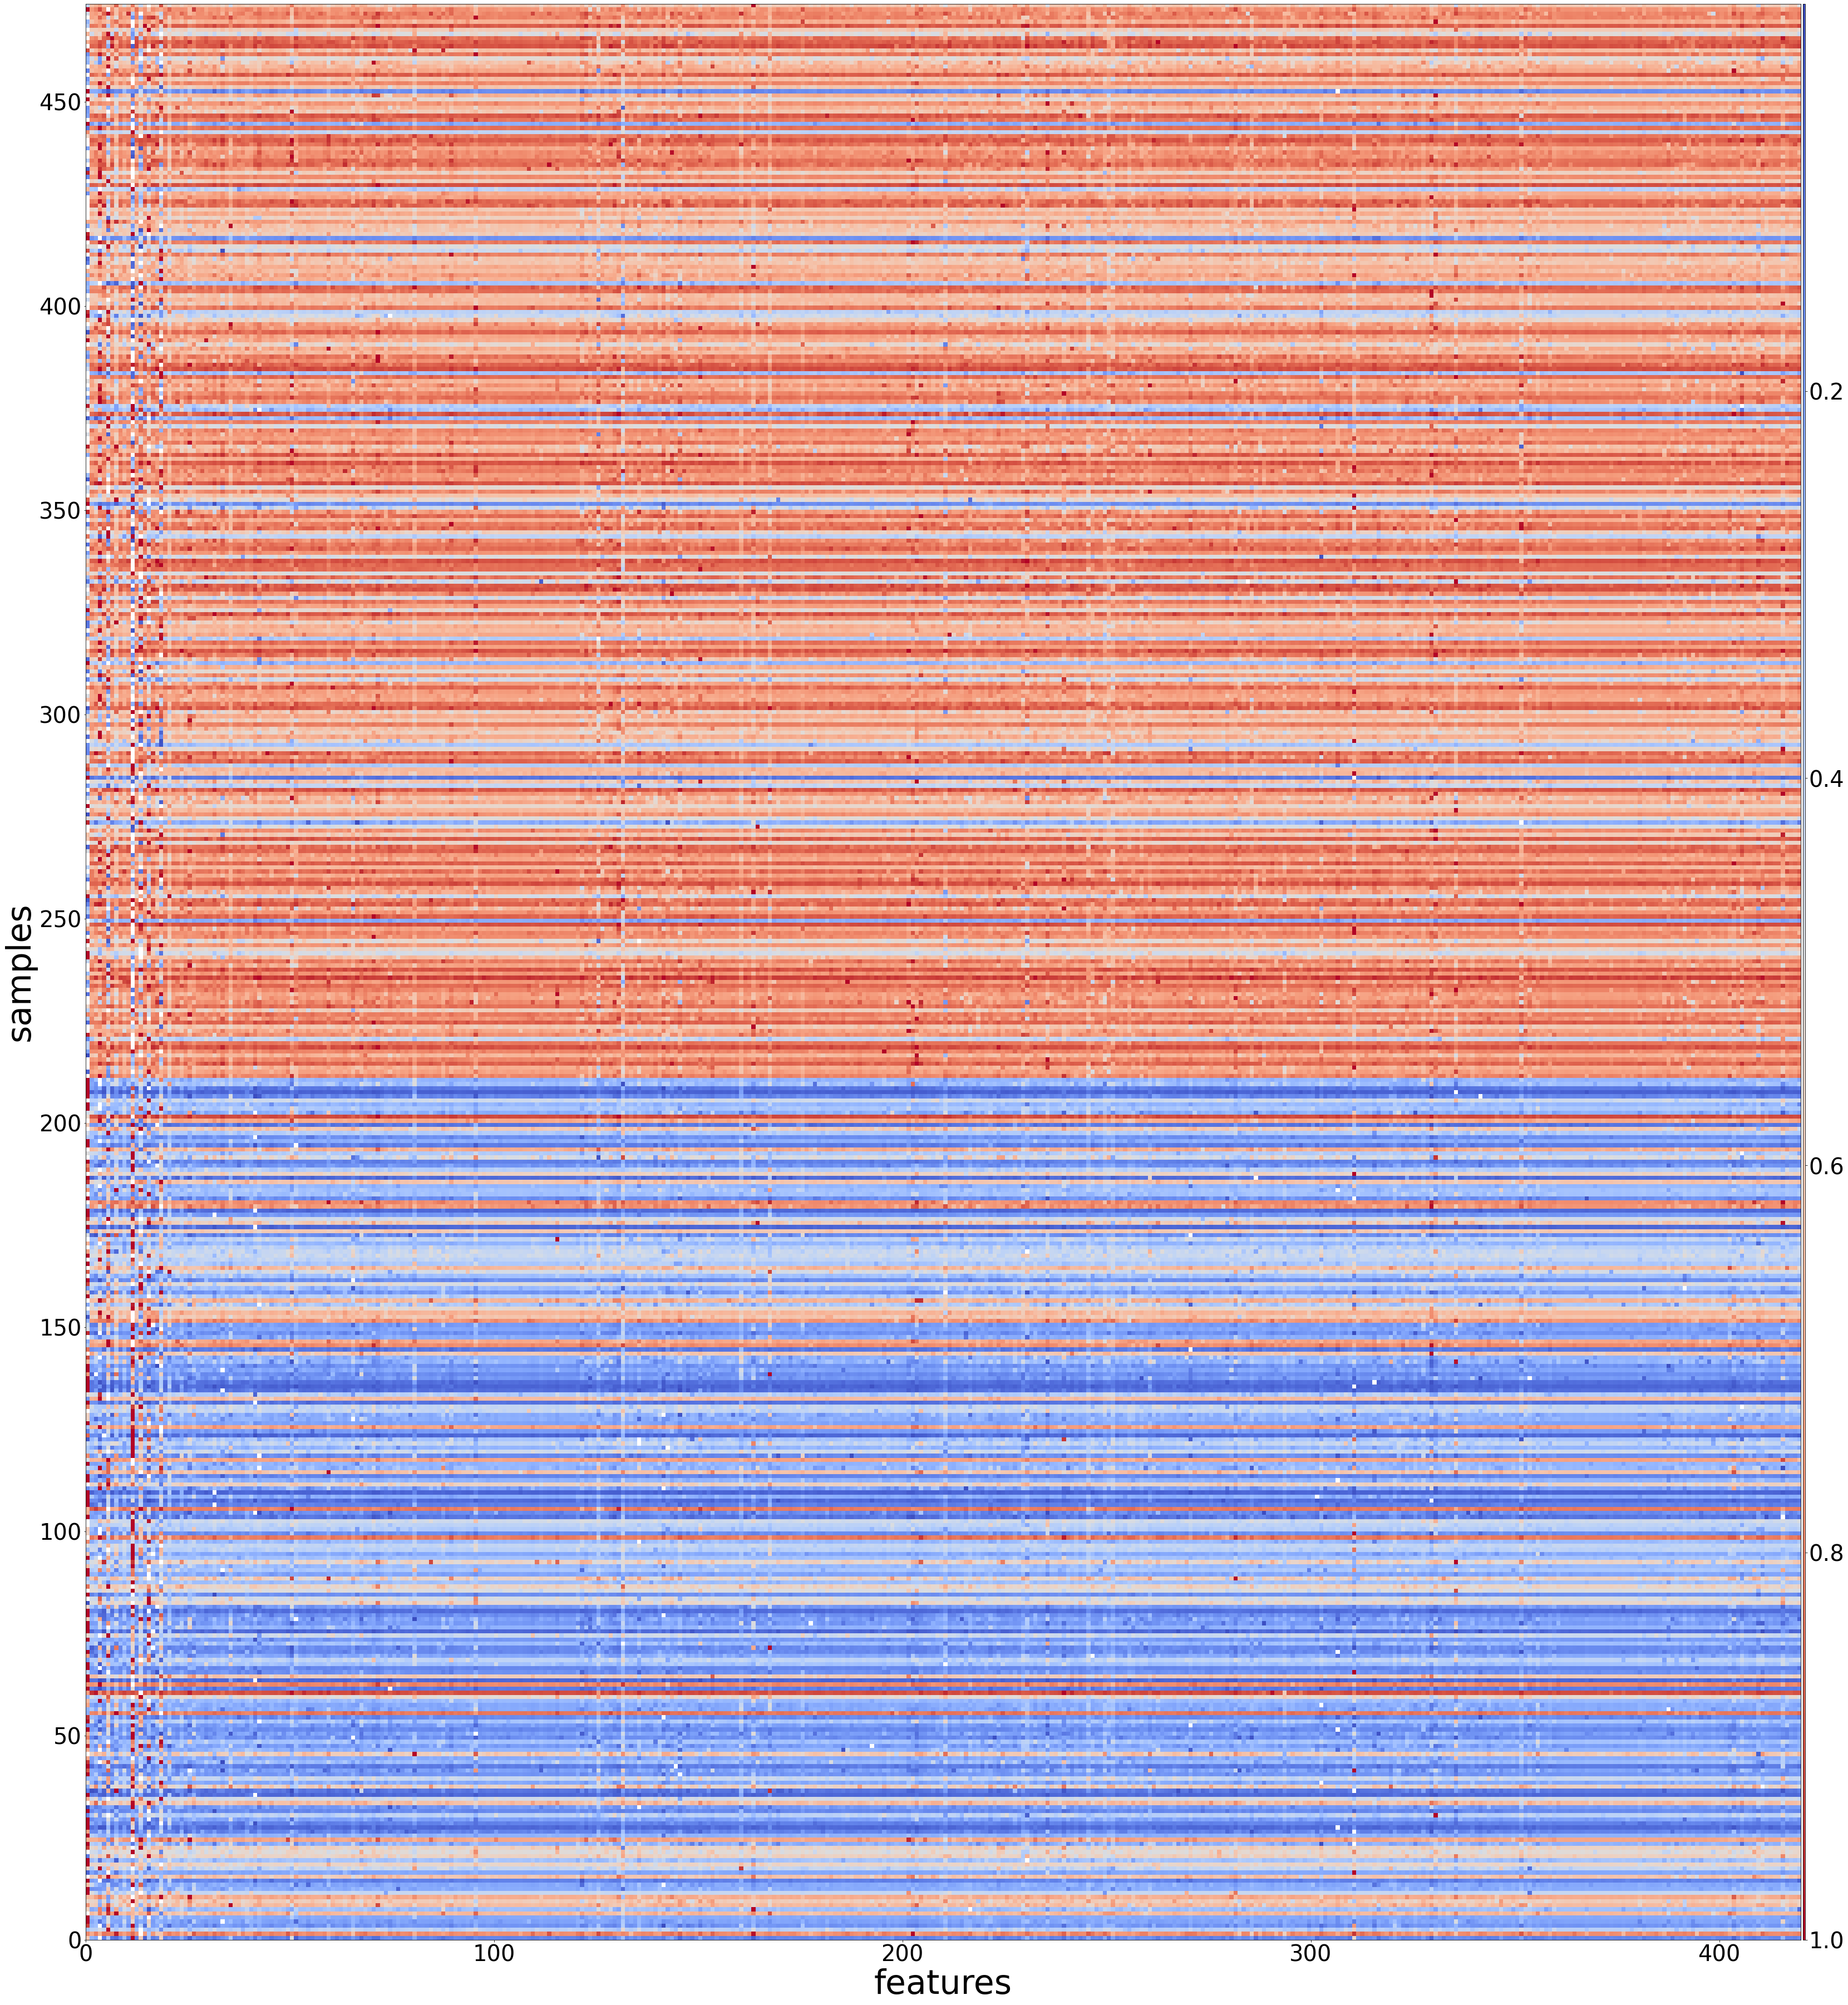

In [32]:
analysisPlot.showMatWithVal(matForPlot,showText=False,figSize=(64,64),cmapName='coolwarm',
                            yticks=np.arange(0,500,50),ytickLabels=np.arange(0,500,50),
                           xticks=np.arange(0,401,100),xtickLabels=np.arange(0,401,100),
                           xtitle='features',ytitle='samples',title_size=60,stick_size=40,
                            saveFig='./tmpOut/shapValT3T4_mat.pdf',saveDpi=300)

Sometimes the global vision is not enouph for figure out what happend in one or few samples, thus here we provided few cells to make detailed comarison:

In [33]:
#this function is to get the fasta seqs from the dataLoader
def getSampleSeqs(sampleIndex,testDataLoadDict):
    thres = len(testDataLoadDict[0][0].names)
    names = []
    outList = []
    for sampleID in sampleIndex:
        if sampleID < thres:
            label = 1
        else:
            label = 0
            sampleID = sampleID - thres
        dataLoader = testDataLoadDict[0][label]
        name = dataLoader.names[sampleID]
        seq = dataLoader.seqs[name]
        names.append(name)
        outList.append(list(seq))
    return np.array(outList,dtype=str),names



You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
FixedFormatter should only be used together with FixedLocator


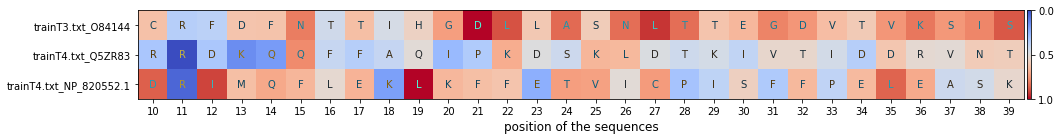

In [34]:
matForPlot = shap_values[0][0]
matForPlot = (matForPlot - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]]))) / (matForPlot.max(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])) - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])))

sampleIndex = [1,15,217] #the rows in the matForPlot
fastaSeqs,names = getSampleSeqs(sampleIndex,testDataLoadDict)
subShapVals = matForPlot[sampleIndex,:]

startPos = 10 #start from 0
endPos = 40
part = slice(startPos,endPos)
analysisPlot.showMatWithText(subShapVals[:,part],fastaSeqs[:,part],vmin=-1e-5,cmapName='coolwarm',
                            xtickLabels = np.arange(startPos,endPos), ytickLabels=names,
                            xtitle='position of the sequences',title_size=12)

<h3>2.4 Visualize the SHAP using LOGO figure</h3>

Using the shap values we can plot the LOGO figure with module Logo maker, below are few demostration of the way generating the plots.

<h4>2.4.1 Preparation</h4>
Before plotting, we have to generate the data frame provided by pandas, which illustrate the relations between the alphabets and the values. Here we provide a class for the such things：<br>
1. Setting the position of the letters (i.e. the posDict).<br>
2. Add the shap values to the right position.<br>
3. Generate the data frame afterwards.<br>

Please note that if you don't want to provide the posDict manually, we provided a default one (i.e. the <i><b>self.posDict</b></i>) for <b>protein</b> in this notebook, be sure the letters are the things you need, and you can change the default one as well.

In [35]:
import pandas as pd
import logomaker

In [77]:
class seqLogoPlot():
    def __init__(self,posDict=None,encodingType='oneHot'):
        if not posDict is None:
            self.posDict = posDict
        else:
            self.posDict = {'G': 0, 'A': 1, 'V': 2, 'L': 3, 'I': 4, 'P': 5,
                               'F': 6, 'Y': 7, 'W': 8, 'S': 9, 'T': 10, 'C': 11,
                               'M': 12, 'N': 13, 'Q': 14, 'D': 15, 'E': 16,
                               'K': 17, 'R': 18, 'H': 19, 'X': 20, 'B': 21,
                               'J': 22, 'O': 23, 'U': 24, 'Z': 25}
        self.posMatDict = {} #pos:resArr
        self.dim = len(list(self.posDict.keys()))
        self.colNames = ['']*self.dim
        for k in self.posDict:
            self.colNames[self.posDict[k]] = k
        self.encodingType = encodingType
        
    def addSeqWithVal(self,seq,vals,posList=None):
        if posList is None:
            posList = np.arange(len(seq),dtype=int)
        if self.encodingType == 'oneHot':
            for i,pos in enumerate(posList):
                if not pos in self.posMatDict:
                    self.posMatDict[pos] = np.zeros(self.dim,dtype=float)
#                 print(self.posMatDict[pos][self.posDict[seq[i]]])
#                 print(vals[i])
                #self.posMatDict[pos][self.posDict[seq[i]]] += vals[i]
                self.posMatDict[pos] += vals[i]
        else:
            for i,pos in enumerate(posList):
                if not pos in self.posMatDict:
                    self.posMatDict[pos] = np.zeros(self.dim,dtype=float)
                resPos = self.posDict[seq[i]]
                self.posMatDict[pos][resPos] += vals[i]
            
    def generateDF(self):
        matList = []
        for pos in range(np.max(list(self.posMatDict.keys()))+1):
            matList.append(self.posMatDict[pos])
        outDF = pd.DataFrame(data=matList,  columns=self.colNames)
        outDF.index.name='pos'
        return outDF

In [78]:
def feedSeqs(dataLoader,vals,seqLogoPlotObj):
    '''
    This function is to feed the object above conveniently since in autoBioSeqpy we have DataLoader which records the necessary information.
    '''
    for sampleID in range(len(dataLoader.seqs)):
        name = dataLoader.names[sampleID]
        seq = dataLoader.seqs[name]
#         print(len(seq))
        val = vals[sampleID]
        seqLogoPlotObj.addSeqWithVal(seq,val)

Having the functions, we can generate the dataFrame in few lines of codes:

In [79]:
#testDataLoadDict[0] for sequences and testDataLoadDict[1] for features, 
#testDataLoadDict[0][0] for positive samples and testDataLoadDict[0][1] for negative
objDataLoader = testDataLoadDict[0][0] 
#shap value is the same construction as dataLoader
objShapValues = shap_values[0][0][:numRows,:]
tmpObjPos = seqLogoPlot(encodingType='dict')
numRows = len(objDataLoader.names)
feedSeqs(objDataLoader,objShapValues,tmpObjPos)

In [80]:
crp_df = tmpObjPos.generateDF()

In [81]:
crp_df

,G,A,V,L,I,P,F,Y,W,S,...,E,K,R,H,X,B,J,O,U,Z
pos,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.044385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.103449,0.367141,0.113041,-0.246115,0.091685,0.281071,-0.128103,-0.149049,-0.062251,1.205967,...,-0.281534,-1.455474,-0.312062,0.074039,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.186504,0.327949,0.082276,-0.358710,0.193970,0.203584,-0.193475,-0.307138,0.000000,0.865532,...,-0.229993,-0.701760,-0.231223,0.027667,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.218425,0.190157,0.198383,-0.461846,0.013993,0.288068,-0.337796,-0.103455,0.000000,1.318913,...,-0.173065,-0.632158,-0.158255,0.143492,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.187448,0.346400,0.113715,-0.286945,-0.055622,0.206119,-0.205338,-0.092874,-0.035703,1.512527,...,-0.155119,-0.682475,-0.068845,0.035189,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.002556,0.000000,0.000000,0.004815,0.000000,0.000000,0.002421,0.000000,0.000000,0.003050,...,0.000000,0.000000,0.003923,0.000000,-0.010417,0.0,0.0,0.0,0.0,0.0
1496,0.000000,0.006196,0.000000,0.000000,0.000000,0.000000,0.009107,0.000000,0.000000,0.004733,...,0.000000,0.000000,0.000000,0.000000,-0.013403,0.0,0.0,0.0,0.0,0.0
1497,0.000000,0.006740,0.007944,0.005132,0.000000,0.000000,0.000000,0.000000,0.000000,0.005258,...,0.005174,0.000000,0.000000,0.000000,-0.017780,0.0,0.0,0.0,0.0,0.0


<h4>2.4.2 plotting the LOGO figure</h4>
Please note that, in this example, the length of the protein is 1500, which is too long to plot all the LOGOs in one figure, thus here we only use the first 30 residues for plotting.

<h5>2.4.2.1 general plotting</h5>
Here we can use the code provide by Loge maker for the first plotting. Somehow the information seems too much.

In [171]:
startPos = 0
endPos = 30

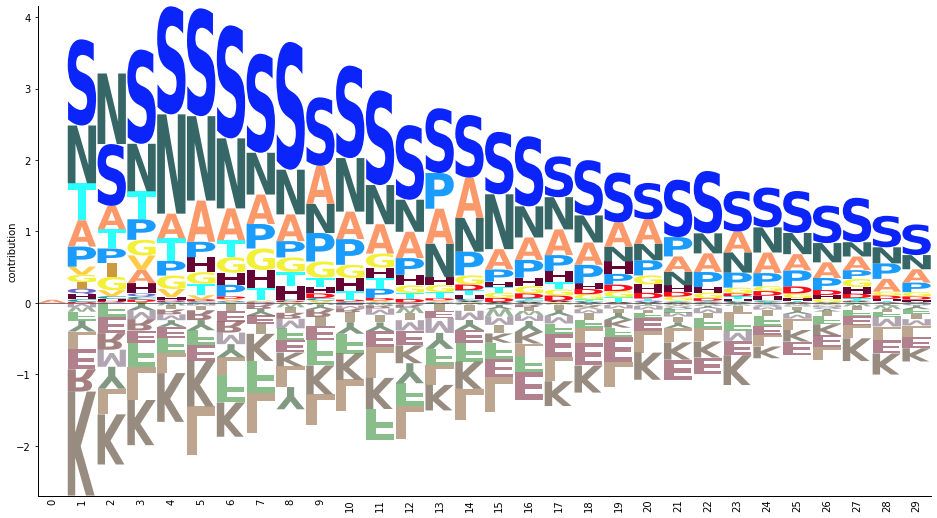

In [93]:
crp_logo = logomaker.Logo(crp_df.iloc[startPos:endPos,:],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9),
                         color_scheme='skylign_protein')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("contribution", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()

<h5>2.4.2.2 plotting with threshold</h5>
To reduce the less important information, here we set a threhold for filtering.

In [96]:
global_threshold = 0.3
crp_df1 = crp_df.copy()
crp_df1.iloc[crp_df1.abs()<global_threshold] = 0

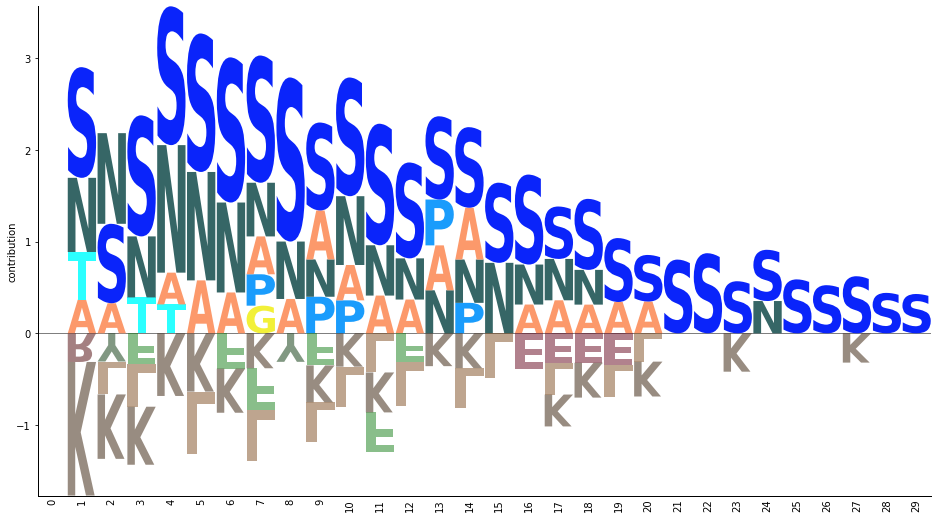

In [97]:
crp_logo = logomaker.Logo(crp_df1.iloc[startPos:endPos,:],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9),
                         color_scheme='skylign_protein')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("contribution", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()

<h5>2.4.2.3 plotting with row wise scaling</h5>
Similarily, we can scale the values of every row (i.e. every residue) into [-1,1], which can make the filtering different.

In [157]:
global_threshold = 0.2
crp_df2 = crp_df.copy().iloc[:,:-5]
# crp_df2.iloc[crp_df2<global_threshold] = 0
for i in range(crp_df2.shape[0]):
    tmpArr = crp_df2.copy().iloc[i,:]
    crp_df2.iloc[i,:] = ((tmpArr-np.min(tmpArr)) / (np.max(tmpArr)-np.min(tmpArr)) - 0.5) / 2

# crp_df2 = ((diff / scale) - 0.5) / 2
crp_df2[crp_df2.abs()<global_threshold] = 0

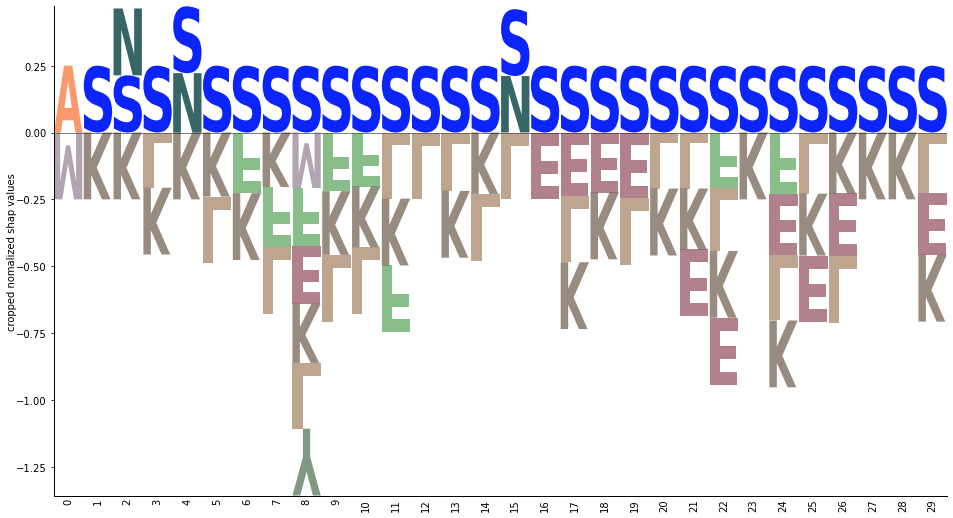

In [158]:
crp_logo = logomaker.Logo(crp_df2.iloc[startPos:endPos,:],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9),
                         color_scheme='skylign_protein')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("cropped nomalized shap values", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)



# style and show figure
crp_logo.fig.show()

<h5>2.4.2.4 plotting with row wise softmax</h5>
Finally, we would like to show the widely used nomalization in deep learning named 'softmax': $$ \dfrac{x_i}{\sum_{j} exp(x_j)} $$<br>
Additionally, the threshold is set to 0.05, which is the average of 20 elements with sum of 1.

In [169]:
global_threshold = 1/20
crp_df3= crp_df.copy().iloc[:,:-5]
# crp_df2.iloc[crp_df2<global_threshold] = 0
for i in range(crp_df3.shape[0]):
    tmpArr = np.exp(crp_df3.copy().iloc[i,:])
    crp_df3.iloc[i,:] = tmpArr/tmpArr.sum()

# crp_df2 = ((diff / scale) - 0.5) / 2
crp_df3[crp_df3.abs()<global_threshold] = 0

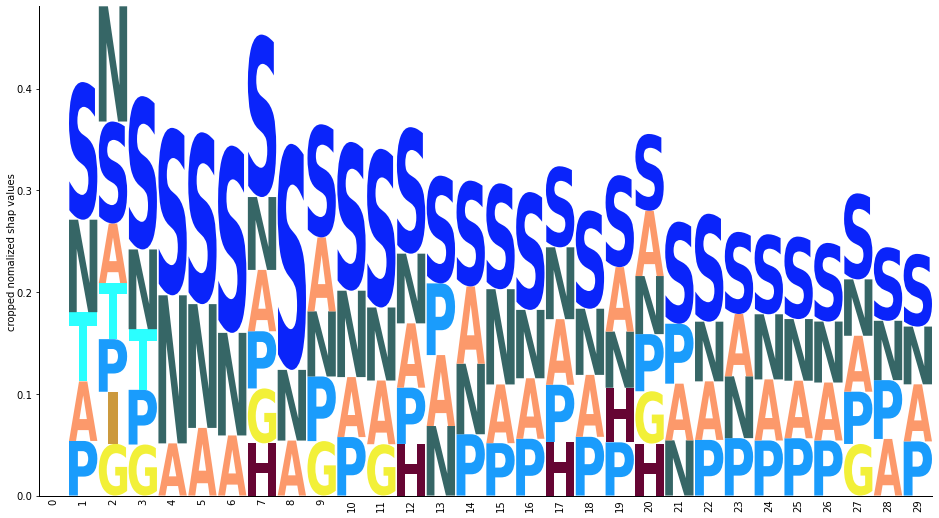

In [170]:
crp_logo = logomaker.Logo(crp_df3.iloc[startPos:endPos,:],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9),
                         color_scheme='skylign_protein')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("cropped nomalized shap values", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)



# style and show figure
crp_logo.fig.show()

That's all the informations for this notebook. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.